# --- Instalasi dan Inisialisasi PySpark ---

In [105]:
!pip install pyspark

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, year, month, dayofmonth, hour, sum, count, lit, avg, round, countDistinct, date_format, to_date, concat, regexp_replace, lag, min, max, collect_list
from pyspark.sql.types import IntegerType, FloatType, StringType, TimestampType
from pyspark.sql.window import Window
from pyspark.ml.fpm import FPGrowth
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from datetime import datetime, timedelta

In [106]:
spark = SparkSession.builder \
    .appName("SupermarketSalesAnalysis") \
    .config("spark.memory.offHeap.enabled", "true") \
    .config("spark.memory.offHeap.size", "2g") \
    .getOrCreate()

print("SparkSession created successfully!")

SparkSession created successfully!


In [107]:
file_path = "SuperMarketAnalysis.csv"

df = spark.read.csv(file_path, header=True, inferSchema=True)

original_cols = df.columns
clean_cols = [c.replace(' ', '_').replace('.', '').lower() for c in original_cols]
df = df.toDF(*clean_cols)

df = df.withColumn("transaction_datetime",
                    to_timestamp(
                        concat(col("date"), lit(" "), col("time")),
                        "M/d/yyyy h:mm:ss a"
                    ))

print("\n--- Initial DataFrame Schema & Data Sample ---")
df.printSchema()
df.show(5, truncate=True)


--- Initial DataFrame Schema & Data Sample ---
root
 |-- invoice_id: string (nullable = true)
 |-- branch: string (nullable = true)
 |-- city: string (nullable = true)
 |-- customer_type: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- product_line: string (nullable = true)
 |-- unit_price: double (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- tax_5%: double (nullable = true)
 |-- sales: double (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)
 |-- payment: string (nullable = true)
 |-- cogs: double (nullable = true)
 |-- gross_margin_percentage: double (nullable = true)
 |-- gross_income: double (nullable = true)
 |-- rating: double (nullable = true)
 |-- transaction_datetime: timestamp (nullable = true)

+-----------+------+---------+-------------+------+--------------------+----------+--------+-------+--------+---------+-----------+-----------+------+-----------------------+------------+------+------------

# --- Pembersihan Data ---

In [108]:
df_cleaned = df.dropna(subset=["sales", "product_line", "transaction_datetime"])
df_cleaned = df_cleaned.filter((col("quantity") > 0) & (col("unit_price") > 0))
df_cleaned = df_cleaned.dropDuplicates(["invoice_id", "product_line"])
df_cleaned = df_cleaned.withColumn("product_line", regexp_replace(col("product_line"), "^\\s+|\\s+$", ""))

print("\n--- Cleaned DataFrame Sample ---")
df_cleaned.show(5, truncate=True)


--- Cleaned DataFrame Sample ---
+-----------+------+---------+-------------+------+-------------------+----------+--------+-------+--------+---------+-----------+-----------+------+-----------------------+------------+------+--------------------+
| invoice_id|branch|     city|customer_type|gender|       product_line|unit_price|quantity| tax_5%|   sales|     date|       time|    payment|  cogs|gross_margin_percentage|gross_income|rating|transaction_datetime|
+-----------+------+---------+-------------+------+-------------------+----------+--------+-------+--------+---------+-----------+-----------+------+-----------------------+------------+------+--------------------+
|101-17-6199|  Alex|   Yangon|       Normal|  Male| Food and beverages|     45.79|       7|16.0265|336.5565|3/13/2019| 7:44:00 PM|Credit card|320.53|            4.761904762|     16.0265|   7.0| 2019-03-13 19:44:00|
|101-81-4070|  Giza|Naypyitaw|       Member|Female|  Health and beauty|     62.82|       2|  6.282| 131.92

# --- Transformasi Data ---

In [109]:
df_transformed = df_cleaned.withColumn("date", to_date(col("date"), "M/d/yyyy")) \
                           .withColumn("year", year(col("transaction_datetime"))) \
                           .withColumn("month", month(col("transaction_datetime"))) \
                           .withColumn("day", dayofmonth(col("transaction_datetime"))) \
                           .withColumn("hour", hour(col("transaction_datetime"))) \
                           .withColumn("day_of_week", date_format(col("transaction_datetime"), "E"))

print("\n--- Transformed DataFrame Schema & Data Sample ---")
df_transformed.printSchema()
df_transformed.show(5)


--- Transformed DataFrame Schema & Data Sample ---
root
 |-- invoice_id: string (nullable = true)
 |-- branch: string (nullable = true)
 |-- city: string (nullable = true)
 |-- customer_type: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- product_line: string (nullable = true)
 |-- unit_price: double (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- tax_5%: double (nullable = true)
 |-- sales: double (nullable = true)
 |-- date: date (nullable = true)
 |-- time: string (nullable = true)
 |-- payment: string (nullable = true)
 |-- cogs: double (nullable = true)
 |-- gross_margin_percentage: double (nullable = true)
 |-- gross_income: double (nullable = true)
 |-- rating: double (nullable = true)
 |-- transaction_datetime: timestamp (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day_of_week: string (nullable = true)

+-----------+

# --- Analisis dan Visualisasi

## Monthly Sales Trend

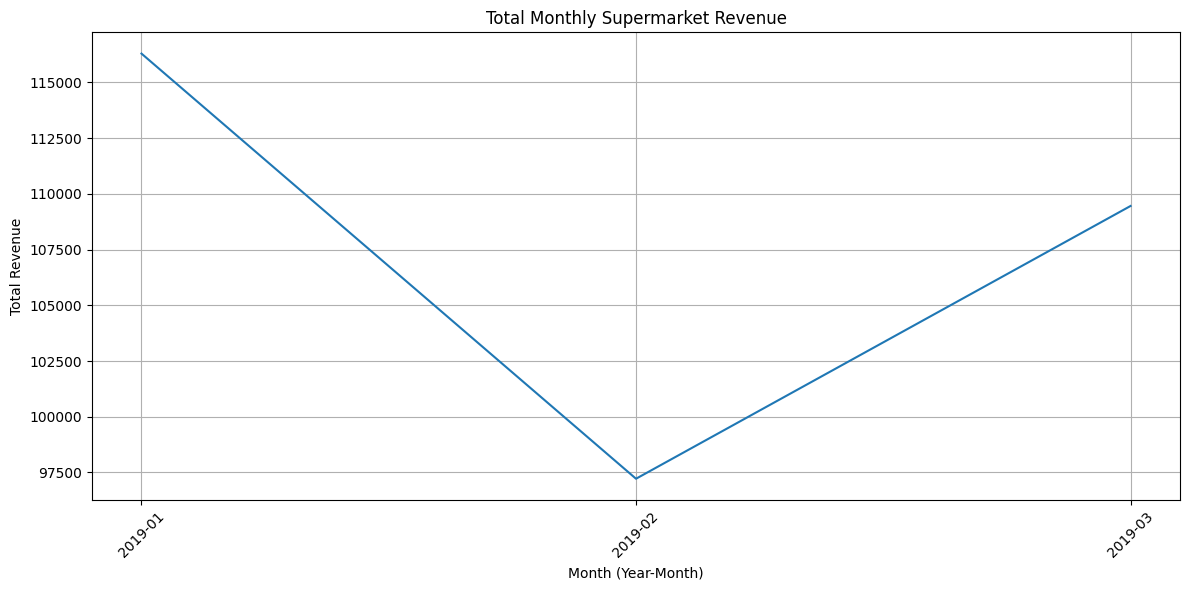

In [110]:
monthly_sales = df_transformed.groupBy("year", "month") \
                              .agg(sum("sales").alias("TotalRevenue")) \
                              .orderBy("year", "month") \
                              .toPandas()

monthly_sales['YearMonth'] = monthly_sales['year'].astype(str) + '-' + monthly_sales['month'].astype(str).str.zfill(2)

plt.figure(figsize=(12, 6))
sns.lineplot(x='YearMonth', y='TotalRevenue', data=monthly_sales)
plt.title("Total Monthly Supermarket Revenue")
plt.xlabel("Month (Year-Month)")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## Top 10 Product Categories by Revenue

/tmp/ipython-input-111-1278907310.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="TotalRevenue", y="product_line", data=top_product_lines, palette="viridis")


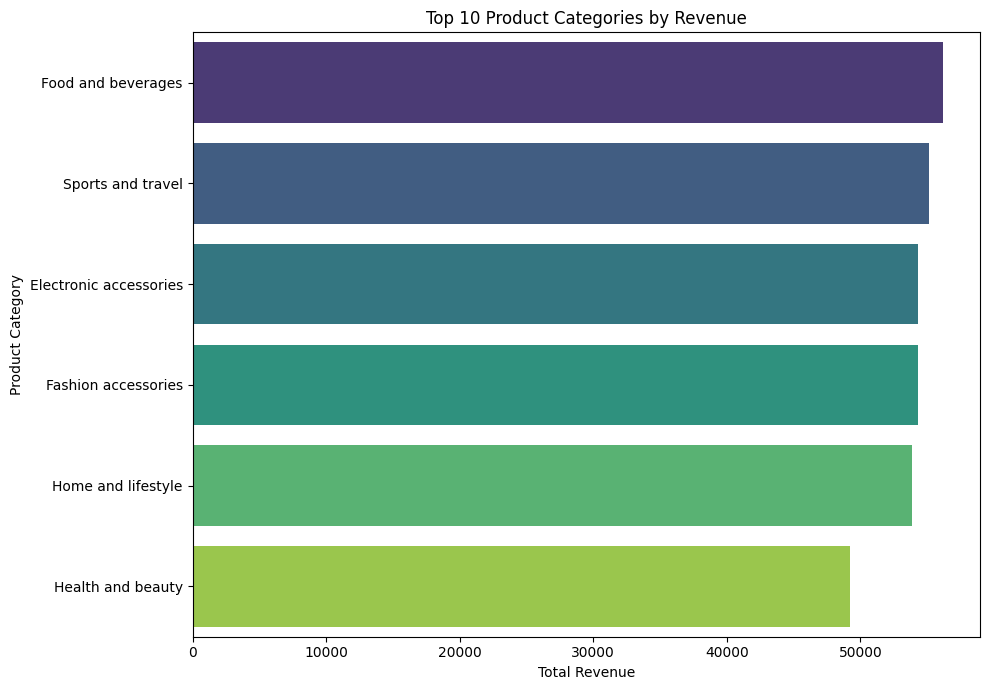

In [111]:
top_product_lines = df_transformed.groupBy("product_line") \
                                 .agg(sum("sales").alias("TotalRevenue")) \
                                 .orderBy(col("TotalRevenue").desc()) \
                                 .limit(10) \
                                 .toPandas()

plt.figure(figsize=(10, 7))
sns.barplot(x="TotalRevenue", y="product_line", data=top_product_lines, palette="viridis")
plt.title("Top 10 Product Categories by Revenue")
plt.xlabel("Total Revenue")
plt.ylabel("Product Category")
plt.tight_layout()
plt.show()

## Sales by Branch and City

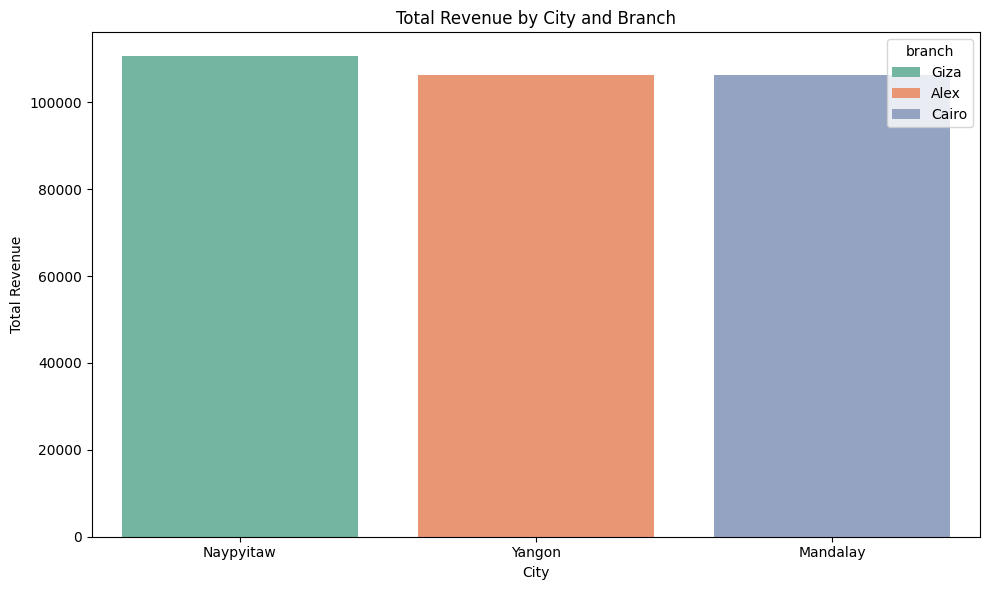

In [112]:
sales_by_branch_city = df_transformed.groupBy("branch", "city") \
                                     .agg(sum("sales").alias("TotalRevenue")) \
                                     .orderBy(col("TotalRevenue").desc()) \
                                     .toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x="city", y="TotalRevenue", hue="branch", data=sales_by_branch_city, palette="Set2")
plt.title("Total Revenue by City and Branch")
plt.xlabel("City")
plt.ylabel("Total Revenue")
plt.tight_layout()
plt.show()

## Peak Sales Hours

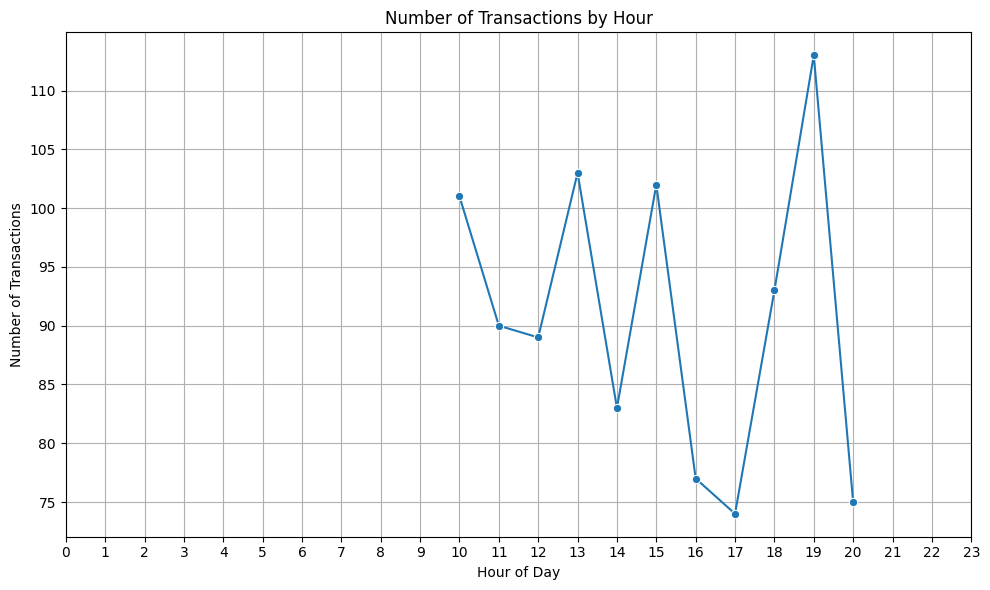

In [113]:
sales_by_hour = df_transformed.groupBy("hour") \
                              .agg(count("invoice_id").alias("TransactionCount")) \
                              .orderBy("hour") \
                              .toPandas()

plt.figure(figsize=(10, 6))
sns.lineplot(x="hour", y="TransactionCount", data=sales_by_hour, marker='o')
plt.title("Number of Transactions by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Transactions")
plt.xticks(range(24))
plt.grid(True)
plt.tight_layout()
plt.show()

## Sales by Customer Type and Gender

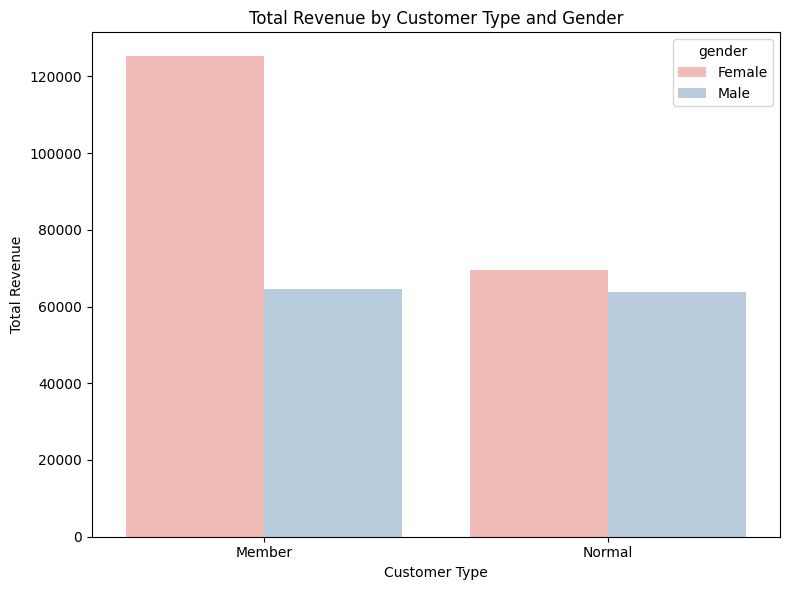

In [114]:
sales_by_customer_gender = df_transformed.groupBy("customer_type", "gender") \
                                        .agg(sum("sales").alias("TotalRevenue")) \
                                        .orderBy(col("customer_type"), col("gender")) \
                                        .toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(x="customer_type", y="TotalRevenue", hue="gender", data=sales_by_customer_gender, palette="Pastel1")
plt.title("Total Revenue by Customer Type and Gender")
plt.xlabel("Customer Type")
plt.ylabel("Total Revenue")
plt.tight_layout()
plt.show()

## Market Basket Analysis

In [115]:
items_per_transaction = df_transformed.groupBy("invoice_id").agg(collect_list("product_line").alias("items"))

fp_growth = FPGrowth(itemsCol="items", minSupport=0.01, minConfidence=0.2)
model = fp_growth.fit(items_per_transaction)

print("\n--- Frequent Itemsets ---")
model.freqItemsets.orderBy(col("freq").desc()).show(10, truncate=False)

print("\n--- Association Rules ---")
rules = model.associationRules
rules.orderBy(col("confidence").desc()).show(10, truncate=False)

if not rules.isEmpty():
    rules_pd = rules.orderBy(col("confidence").desc()).limit(5).toPandas()
    rules_pd['antecedent_str'] = rules_pd['antecedent'].apply(lambda x: ', '.join(x))
    rules_pd['consequent_str'] = rules_pd['consequent'].apply(lambda x: ', '.join(x))

    plt.figure(figsize=(10, 6))
    sns.barplot(x="confidence", y="antecedent_str", hue="consequent_str", data=rules_pd, palette="tab10")
    plt.title("Top 5 Association Rules (by Confidence)")
    plt.xlabel("Confidence")
    plt.ylabel("If Purchased (Antecedent)")
    plt.legend(title="Then Also Purchase (Consequent)", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("No association rules found with the current minSupport and minConfidence. Try adjusting them.")



--- Frequent Itemsets ---
+------------------------+----+
|items                   |freq|
+------------------------+----+
|[Fashion accessories]   |178 |
|[Food and beverages]    |174 |
|[Electronic accessories]|170 |
|[Sports and travel]     |166 |
|[Home and lifestyle]    |160 |
|[Health and beauty]     |152 |
+------------------------+----+


--- Association Rules ---
+----------+----------+----------+----+-------+
|antecedent|consequent|confidence|lift|support|
+----------+----------+----------+----+-------+
+----------+----------+----------+----+-------+

No association rules found with the current minSupport and minConfidence. Try adjusting them.


## Prediksi Harga Vs Harga Asli

RMSE for Daily Revenue Prediction: 908.2630003996369


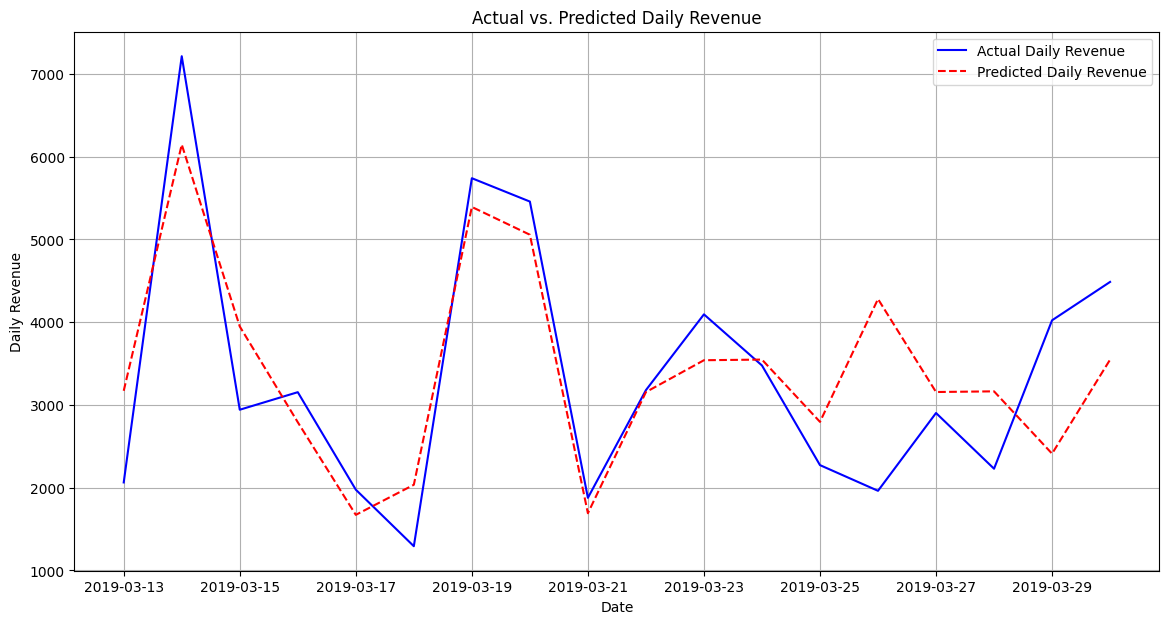

SparkSession stopped.


In [116]:
daily_sales = df_transformed.groupBy("date") \
                            .agg(sum("sales").alias("DailyRevenue"),
                                 count("invoice_id").alias("DailyTransactions")) \
                            .orderBy("date")
window_spec_daily = Window.orderBy("date")
daily_sales = daily_sales.withColumn("prev_daily_revenue", lag(col("DailyRevenue"), 1).over(window_spec_daily))
daily_sales = daily_sales.dropna(subset=["prev_daily_revenue"])

# Feature Engineering
feature_cols_pred = ["prev_daily_revenue", "DailyTransactions"]
assembler_pred = VectorAssembler(inputCols=feature_cols_pred, outputCol="raw_features_pred")
scaler_pred = StandardScaler(inputCol="raw_features_pred", outputCol="features_pred", withStd=True, withMean=True)
split_ratio = 0.8
num_records = daily_sales.count()
split_point = int(num_records * split_ratio)

training_data_pred = daily_sales.limit(split_point)
test_data_pred = daily_sales.subtract(training_data_pred)

# Build and fit prediction pipeline
pipeline_pred = Pipeline(stages=[assembler_pred, scaler_pred])
pipeline_model_pred = pipeline_pred.fit(training_data_pred)
training_data_pred_processed = pipeline_model_pred.transform(training_data_pred)
test_data_pred_processed = pipeline_model_pred.transform(test_data_pred)

# Train Linear Regression model
lr_pred = LinearRegression(featuresCol="features_pred", labelCol="DailyRevenue", maxIter=10, regParam=0.1)
lr_model_pred = lr_pred.fit(training_data_pred_processed)
predictions_pred = lr_model_pred.transform(test_data_pred_processed)

# Evaluate model
evaluator_rmse_pred = RegressionEvaluator(labelCol="DailyRevenue", predictionCol="prediction", metricName="rmse")
rmse_pred = evaluator_rmse_pred.evaluate(predictions_pred)
print(f"RMSE for Daily Revenue Prediction: {rmse_pred}")

# Visualize predictions vs actual
predictions_pd_pred = predictions_pred.select("date", "DailyRevenue", "prediction").orderBy("date").toPandas()

plt.figure(figsize=(14, 7))
plt.plot(predictions_pd_pred["date"], predictions_pd_pred["DailyRevenue"], label="Actual Daily Revenue", color="blue")
plt.plot(predictions_pd_pred["date"], predictions_pd_pred["prediction"], label="Predicted Daily Revenue", color="red", linestyle="--")
plt.title("Actual vs. Predicted Daily Revenue")
plt.xlabel("Date")
plt.ylabel("Daily Revenue")
plt.legend()
plt.grid(True)
plt.show()

spark.stop()
print("SparkSession stopped.")